In [130]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

import random

#

import matplotlib.pyplot as plt

from pandasgui import show

#

import warnings

#

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

import sklearn.metrics as metrics

In [131]:
warnings.filterwarnings( 'ignore' )

In [132]:
gmID_list = cfs.list_whitelisted_gmIDs()

topic_list = cfs.list_topics()

print( topic_list )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [133]:
def MovingFunction( df, moving_colname, window, operation, desired_colnames ):

    if ( operation == 'mean' ):

        def operation_func( arraylike_obj ): return np.mean( arraylike_obj )

    elif ( operation == 'median' ):

        def operation_func( arraylike_obj ): return np.median( arraylike_obj )

    elif ( operation == 'overall_diff' ):

        def operation_func( arraylike_obj ): return ( arraylike_obj[ -1 ] - arraylike_obj[ 0 ] )

    elif ( operation == 'mean_diff' ):

        def operation_func( arraylike_obj ): 

            if ( len( arraylike_obj ) > 1 ):

                return ( np.mean( np.diff( arraylike_obj ) ) )

            elif ( len( arraylike_obj ) == 1 ):

                return 0

    elif ( operation == 'stddev' ):

        def operation_func( arraylike_obj ): return ( np.std( arraylike_obj ) )

    #

    moving_col = np.array( df[ moving_colname ] )

    moving_col_diff = np.diff( moving_col )

    #
    
    desired_cols = [ np.array( df[ desired_colname ] ) for desired_colname in desired_colnames ]

    #

    output_colnames = [ f'{ desired_colname }_{ operation }' for desired_colname in desired_colnames ]

    #

    window_indexes_list = []

    for index in range( 1, len( moving_col ) ):

        window_end_index = index - 1

        #

        value_sum = moving_col_diff[ window_end_index ]

        window_start_index = window_end_index

        while ( ( value_sum < window ) and ( window_start_index > 0 ) ):

            window_start_index = window_start_index - 1

            value_sum = value_sum + moving_col_diff[ window_start_index ]

        #

        window_indexes = [ i for i in range( window_start_index, window_end_index + 1 ) ]

        window_indexes_list.append( window_indexes )

    window_indexes_list = [ window_indexes_list[ 0 ] ] + window_indexes_list

    #

    output_cols = []

    for desired_col in desired_cols:

        output_col = []

        for window_indexes in window_indexes_list:

            output_col.append( operation_func( desired_col[ window_indexes ] ) )

        output_cols.append( output_col )

    #

    for output_colname, output_col in zip( output_colnames, output_cols ):

        df[ output_colname ] = output_col

In [134]:
def BinaryDisengagement( df ):

    TernaryDrivingModeTransition_col = df[ 'TernaryDrivingModeTransition' ]

    BinaryDisengagement_col = []

    for val in TernaryDrivingModeTransition_col:

        if ( ( val == 0 ) or ( val == 1 ) ):

            BinaryDisengagement_col.append( 0 )

        elif ( val == -1 ):

            BinaryDisengagement_col.append( 1 )

    df[ 'BinaryDisengagement' ] = BinaryDisengagement_col

In [135]:
def BinaryDisengagementExpanded( df, moving_colname, window ):

    moving_col = np.array( df[ moving_colname ] )

    moving_col_diff = np.diff( moving_col )

    #

    BinaryDisengagement_col = np.array( df[ 'BinaryDisengagement' ] )

    disengagement_indexes = np.where( BinaryDisengagement_col == 1 )[ 0 ]

    #
    
    window_indexes_list = []

    for index in disengagement_indexes:
        
        window_indexes = [ index ]

        cur_loop_index = index - 1

        value_sum = moving_col_diff[ cur_loop_index ]

        while ( ( value_sum <= window ) and ( cur_loop_index > -1 ) ):

            window_indexes = [ cur_loop_index ] + window_indexes

            #

            cur_loop_index = cur_loop_index - 1

            value_sum = value_sum + moving_col_diff[ cur_loop_index ]

        window_indexes_list.append( window_indexes )

    #

    BinaryDisengagementExpanded_col = np.copy( BinaryDisengagement_col )

    for window_indexes in window_indexes_list:

        BinaryDisengagementExpanded_col[ window_indexes ] = 1

    #

    df[ 'BinaryDisengagementExpanded' ] = BinaryDisengagementExpanded_col

In [136]:
def Index( df ):

    num_of_rows = df.shape[ 0 ]

    df[ 'Ind' ] = [ index for index in range( num_of_rows ) ]

In [137]:
def Distance( df ):

    time_array = np.array( df[ 'time' ] ) * 1e-9 # seconds

    speedMps_array = np.array( df[ 'speedMps' ] ) # meters/second

    #

    deltatime_array = np.diff( time_array )

    deltatime_array = np.insert( deltatime_array, 0, deltatime_array[ 0 ] )

    #

    deltadistance_array = deltatime_array * speedMps_array #meters

    Distance_col = np.cumsum( deltadistance_array )

    #

    df[ 'Distance' ] = Distance_col

In [138]:
def DisengagementID( df, expanded = False ):

    gmID = df[ 'groupMetadataID' ][ 0 ]
    
    #

    if ( expanded == False ):

        disengagment_col = np.array( df[ 'BinaryDisengagement' ] )

        string1 = ''

        string2 = ''

    elif ( expanded == True ):

        disengagment_col = np.array( df[ 'BinaryDisengagementExpanded' ] )

        string1 = 'Expanded'

        string2 = 'e'

    #

    disengagement_indexes = np.where( disengagment_col == 1 )[ 0 ]

    #

    DisengagementID_col = [ 'NAD' for i in disengagment_col ]

    counter = 0

    for index in disengagement_indexes:

        DisengagementID_col[ index ] = f'{ gmID }_{ counter }{ string2 }'

        counter = counter + 1

    df[ f'Disengagement{ string1 }ID' ] = DisengagementID_col

In [139]:
def random_list_split( input_list, split_percentage = 0.5 ):

    randomized_input_list = random.shuffle( input_list )

    #

    list_len = len( input_list )

    split_index = round( list_len * split_percentage )

    split_list1 = input_list[ : split_index ]

    split_list2 = input_list[ split_index : ]

    return split_list1, split_list2

In [140]:
red_combined_dfs = []

green_combined_dfs = []

blue_combined_dfs = []

for gmID in gmID_list:

    chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    chassis_df = chassis_df.sort_values( 'time' )

    best_pose_df = best_pose_df.sort_values( 'time' )

    #

    Index( chassis_df )

    #

    cfs.BinaryDrivingMode( chassis_df )

    cfs.TernaryDrivingModeTransition( chassis_df )

    BinaryDisengagement( chassis_df )

    #

    DisengagementID( chassis_df, expanded = False )

    #

    cfs.Acceleration( chassis_df )

    #

    cfs.LatLonTotalStdDev( best_pose_df )

    #

    cfs.ProgressAlongRoute_v2( best_pose_df )

    #

    cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

    #

    combined_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    #

    columns_to_keep = [ 'Ind', 'time_x', 'speedMps', 'Acceleration', 'brakePercentage', 'throttlePercentage', 'steeringPercentage', \
                        'LatLonTotalStdDev', 'BinaryDrivingMode', 'BinaryDisengagement', 'DisengagementID', 'groupMetadataID_x', 'longitude', 'latitude', \
                        'ProgressAlongRoute' ]

    combined_df = combined_df[ columns_to_keep ]

    combined_df = combined_df.rename( columns = { 'groupMetadataID_x': 'groupMetadataID', 'time_x': 'time' } )

    #

    combined_df[ 'steeringPercentage' ] = np.abs( combined_df[ 'steeringPercentage' ] )

    combined_df = combined_df.rename( columns = { 'steeringPercentage': 'abs_steeringPercentage' } )

    #

    limited_stddev_list = []

    for stddev in combined_df[ 'LatLonTotalStdDev' ]:

        if ( stddev > 10 ):

            stddev = 10

        limited_stddev_list.append( stddev )

    combined_df[ 'LatLonTotalStdDev' ] = limited_stddev_list

    combined_df = combined_df.rename( columns = { 'LatLonTotalStdDev': 'limited_LatLonTotalStdDev' } )

    #

    if ( cfs.give_route( gmID ) == 'Red' ):

        red_combined_dfs.append( combined_df )

    elif ( cfs.give_route( gmID ) == 'Green' ):

        green_combined_dfs.append( combined_df )

    elif ( cfs.give_route( gmID ) == 'Blue' ):

        blue_combined_dfs.append( combined_df )

In [141]:
all_combined_dfs = red_combined_dfs + green_combined_dfs + blue_combined_dfs

all_combined_df = pd.concat( all_combined_dfs )

del all_combined_dfs

In [143]:
BinaryDisengagement_valuecounts = all_combined_df[ 'BinaryDisengagement' ].value_counts()

disengagement_percentage = ( BinaryDisengagement_valuecounts[ 1 ] / ( BinaryDisengagement_valuecounts[ 0 ] + BinaryDisengagement_valuecounts[ 1 ] ) ) * 100

print( f'Disengagement %: { disengagement_percentage:.3f}' )

print( f'# of Non-Disengagements: { BinaryDisengagement_valuecounts[ 0 ] }' )

print( f'# of Disengagements: { BinaryDisengagement_valuecounts[ 1 ] }' )

Disengagement %: 0.019
# of Non-Disengagements: 11424607
# of Disengagements: 2217


In [154]:
BinaryDrivingMode_valuecounts = all_combined_df[ 'BinaryDrivingMode' ].value_counts()

manual_percentage = ( BinaryDrivingMode_valuecounts[ 0 ] / ( BinaryDrivingMode_valuecounts[ 0 ] + BinaryDrivingMode_valuecounts[ 1 ] ) ) * 100

print( f'Manual %: { manual_percentage:.3f}' )

print( f'# of Auto: { BinaryDrivingMode_valuecounts[ 1 ] }' )

print( f'# of Manual: { BinaryDrivingMode_valuecounts[ 0 ] }' )

Manual %: 22.629
# of Auto: 8841071
# of Manual: 2585753


In [125]:
mean_metric_list_list = []

for k in range( 1, 4 ):

    print( f'K#: { k }' )

    tn_list = []

    tp_list = []

    fn_list = []

    fp_list = []

    #

    precision_list = []

    recall_list = []

    # f1_score_list = []

    tnr_list = []

    #

    accuracy_list = []

    balanced_accuracy_list = []

    for n in range( 5 ):

        training_red_dfs, testing_red_dfs = random_list_split( red_combined_dfs, split_percentage = 0.8 )

        training_red_df = pd.concat( training_red_dfs )

        testing_red_df = pd.concat( testing_red_dfs )

        #

        X_colnames = [ 'speedMps', 'brakePercentage', 'throttlePercentage', 'abs_steeringPercentage', 'limited_LatLonTotalStdDev' ]

        Y_colname = 'BinaryDisengagement'

        #

        X_train = training_red_df[ X_colnames ]

        Y_train = training_red_df[ Y_colname ]

        #

        X_test = testing_red_df[ X_colnames ]

        Y_test = testing_red_df[ Y_colname ]

        #

        scaler = StandardScaler()

        X_train = scaler.fit_transform( X_train )

        X_test = scaler.transform( X_test )

        #

        knn = KNeighborsClassifier( n_neighbors = k )

        knn.fit( X_train, Y_train )

        Y_pred = knn.predict( X_test )

        #

        cm = metrics.confusion_matrix( Y_test, Y_pred )

        #

        tn = cm[ 0, 0 ]

        tn_list.append( tn )

        tp = cm[ 1, 1 ]

        tp_list.append( tp )

        fn = cm[ 1, 0 ]

        fn_list.append( fn )

        fp = cm[ 0, 1 ]

        fp_list.append( fp )

        #

        precision = tp / ( tp + fp )

        precision_list.append( precision )

        recall = tp / ( tp + fn )

        recall_list.append( recall )

        # f1_score = 2 * ( precision * recall ) / ( precision + recall )

        # f1_score_list.append( f1_score )

        tnr = tn / ( tn + fp )

        tnr_list.append( tnr )

        #

        accuracy = ( tp + tn ) / ( tp + tn + fp + fn )

        accuracy_list.append( accuracy )

        balanced_accuracy = ( recall + tnr ) / 2

        balanced_accuracy_list.append( balanced_accuracy )

    #

    mean_tn = np.mean( tn_list )

    mean_tp = np.mean( tp_list )

    mean_fn = np.mean( fn_list )

    mean_fp = np.mean( fp_list )

    #

    mean_precision = np.mean( precision_list )

    mean_recall = np.mean( recall_list )

    # mean_f1_score = np.mean( f1_score_list )

    mean_tnr = np.mean( tnr_list )

    #

    mean_accuracy = np.mean( accuracy_list )

    mean_balanced_accuracy = np.mean( balanced_accuracy_list )

    #

    mean_metric_list = [ mean_tn, mean_tp, mean_fn, mean_fp, mean_precision, mean_recall, mean_tnr, mean_accuracy, mean_balanced_accuracy ]

    mean_metric_list_list.append( mean_metric_list )

K#: 1
K#: 2
K#: 3


In [208]:
for k in range( 1, 4 ):

    print( f'K-Value: { k }' )

    mean_metric_list = mean_metric_list_list[ k - 1 ]

    print( '' )

    print( f'Mean_False_Negatives: { mean_metric_list[ 2 ] }, Mean_True_Positives: { mean_metric_list[ 1 ] }' )
    
    print( f'Mean_True_Negatives: { mean_metric_list[ 0 ] }, Mean_False_Positives: { mean_metric_list[ 3 ] }' )

    print( '' )

    print( f'Mean_Precision: { mean_metric_list[ 4 ]:.3f}' )

    print( f'Mean_Recall/True_Positive_Rate: { mean_metric_list[ 5 ]:.3f}' )

    print( f'True_Negative_Rate: { mean_metric_list[ 6 ]:.3f}' )

    print( '' )

    print( f'Mean_Accuracy: { mean_metric_list[ 7 ]:.3f}' )

    print( f'Mean_Balanced_Accuracy: { mean_metric_list[ 8 ]:.3f}' )

    print( '\n\n' )
    

K-Value: 1

Mean_False_Negatives: 119.4, Mean_True_Positives: 0.4
Mean_True_Negatives: 777124.8, Mean_False_Positives: 174.6

Mean_Precision: 0.002
Mean_Recall/True_Positive_Rate: 0.003
True_Negative_Rate: 1.000

Mean_Accuracy: 1.000
Mean_Balanced_Accuracy: 0.502



K-Value: 2

Mean_False_Negatives: 128.2, Mean_True_Positives: 0.0
Mean_True_Negatives: 792643.4, Mean_False_Positives: 0.6

Mean_Precision: nan
Mean_Recall/True_Positive_Rate: 0.000
True_Negative_Rate: 1.000

Mean_Accuracy: 1.000
Mean_Balanced_Accuracy: 0.500



K-Value: 3

Mean_False_Negatives: 129.6, Mean_True_Positives: 0.0
Mean_True_Negatives: 727161.8, Mean_False_Positives: 1.2

Mean_Precision: nan
Mean_Recall/True_Positive_Rate: 0.000
True_Negative_Rate: 1.000

Mean_Accuracy: 1.000
Mean_Balanced_Accuracy: 0.500





In [199]:
len( testing_red_dfs )

14

In [129]:
mean_metric_list_list[ 0 ]

[np.float64(777124.8),
 np.float64(0.4),
 np.float64(119.4),
 np.float64(174.6),
 np.float64(0.0019360269360269363),
 np.float64(0.003347807816220759),
 np.float64(0.9997789093317258),
 np.float64(0.9996219403859558),
 np.float64(0.5015633585739733)]

In [118]:
X_colnames = [ 'speedMps', 'brakePercentage', 'throttlePercentage', 'abs_steeringPercentage', 'limited_LatLonTotalStdDev' ]

Y_colname = 'BinaryDisengagement'

#

X_train = training_red_df[ X_colnames ]

Y_train = training_red_df[ Y_colname ]

#

X_test = testing_red_df[ X_colnames ]

Y_test = testing_red_df[ Y_colname ]

In [119]:
scaler = StandardScaler()

X_train = scaler.fit_transform( X_train )

X_test = scaler.transform( X_test )

In [120]:
knn = KNeighborsClassifier( n_neighbors = 1 )

knn.fit( X_train, Y_train )

Y_pred = knn.predict( X_test )

In [121]:
accuracy = accuracy_score( Y_test, Y_pred )
print( "Accuracy:", accuracy )

Accuracy: 0.9994554926635941


In [122]:
balanced_accuracy_score( Y_test, Y_pred )

np.float64(0.4998345903981532)

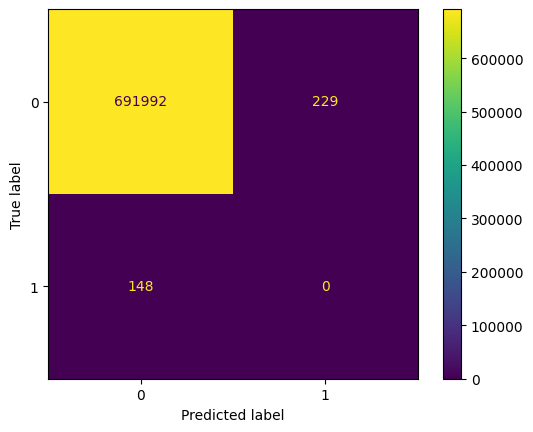

In [123]:
cm = confusion_matrix( Y_test, Y_pred )

disp = ConfusionMatrixDisplay( confusion_matrix = cm )

disp.plot()

In [106]:
cm[ 0, 1 ]

np.int64(177)

In [173]:
test_df = cfs.retrieve_gmID_topic( gmID_list[ 1 ], '/apollo/canbus/chassis' )

test_df = test_df.sort_values( 'time' )

cfs.NormalizedTime( test_df )

Distance( test_df )

In [183]:
MovingFunction( test_df, moving_colname = 'Distance', window = 50 , operation = 'mean', desired_colnames = [ 'speedMps' ] )

In [184]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53079 entries, 0 to 53078
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brakePercentage     53079 non-null  float64
 1   groupMetadataID     53079 non-null  object 
 2   drivingMode         53079 non-null  object 
 3   speedMps            53079 non-null  float64
 4   time                53079 non-null  int64  
 5   throttlePercentage  53079 non-null  float64
 6   steeringPercentage  53079 non-null  float64
 7   signal.turnSignal   53079 non-null  object 
 8   NormalizedTime      53079 non-null  int64  
 9   Distance            53079 non-null  float64
 10  speedMps_mean       53079 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [190]:
cfs.give_route( gmID_list[ 1 ] )

'Blue'

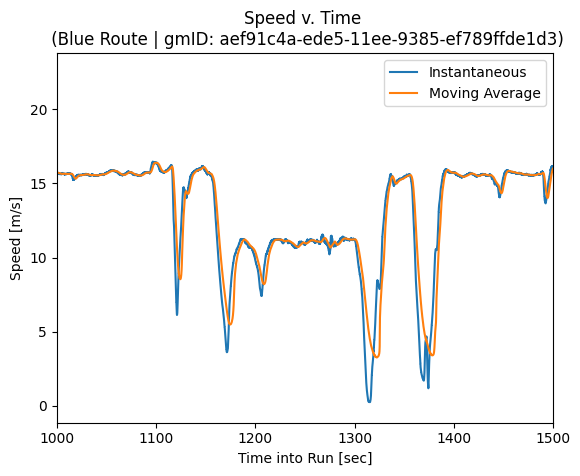

In [196]:
plt.plot( test_df[ 'NormalizedTime' ] * 1e-9, test_df[ 'speedMps' ], label = 'Instantaneous' )

plt.plot( test_df[ 'NormalizedTime' ] * 1e-9, test_df[ 'speedMps_mean' ], label = 'Moving Average' )

plt.xlim( 1000, 1500 )

plt.xlabel( 'Time into Run [sec]' )

plt.ylabel( 'Speed [m/s]' )

plt.title( f'Speed v. Time \n (Blue Route | gmID: { gmID_list[ 1 ] })' )

plt.legend()

plt.show()